# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score
!pip install grad-cam

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-6c2u0s4f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-6c2u0s4f
  Resolved https://github.com/huggingface/transformers to commit bb45d3631ec7026db04a77d33a52b31766372160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-09-07 08:19:32.742997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757233172.766854    3198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757233172.774047    3198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
MIMIC_DATA_PATH = "/kaggle/input/p10-processed-data"

# Keep these parameters from your original code
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 4 # Or whatever your GPU can handle
MAX_SEQ_LENGTH   = 256
IMAGE_SIZE       = 224
TRAIN_RATIO      = 0.80
VALID_RATIO      = 0.10
TEST_RATIO       = 0.10
RANDOM_STATE     = 42

In [6]:
# 2) Cleaning, patient-id extraction, manifest builder (multi-view + patient_id)

import re

_period_collapse = re.compile(r"\.{2,}")
_punct = re.compile(r'[,\?;*!%^&_+():\[\]{}"\\/]+')

def clean_text(text):
    if not text: return ""
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    text = _period_collapse.sub('.', text)
    text = text.strip().lower()
    sents = [s.strip() for s in text.split('.') if s.strip()]
    def sent_clean(s):
        s = _punct.sub('', s)
        s = re.sub(r"\s+", " ", s)
        return s
    tokens = [sent_clean(s) for s in sents if sent_clean(s)]
    report = ' . '.join(tokens) + ' .'
    return report


In [7]:
class MIMIC_CXR_Dataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform=None, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        findings_text = clean_text(item['report_findings'])
        impression_text = clean_text(item['report_impression'])
        full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} <|endoftext|>"
        raw_labels = item['labels']
        chexpert_labels = torch.tensor(
        [1.0 if l == 1.0 else 0.0 for l in raw_labels], dtype=torch.float)
        chexpert_mask = torch.tensor(
        [1.0 if l is not None and l != -1.0 else 0.0 for l in raw_labels], dtype=torch.float)
        image_tensors_pre = item['images']
        image_tensors_post = []

        for img_tensor in image_tensors_pre:
            # === FIX FOR BLACK IMAGE ===
            # 1. Convert tensor [0,1] back to a PIL Image [0,255]
            pil_image = transforms.ToPILImage()(img_tensor)
            # 2. Convert PIL Image to NumPy array, which is the standard [0,255] uint8 format
            image_np = np.array(pil_image)
            # 3. Now, pass this standard format to Albumentations
            # ===========================

            if self.image_transform:
                transformed = self.image_transform(image=image_np)
                image_tensor_aug = transformed['image']
            else:
                image_tensor_aug = img_tensor

            image_tensors_post.append(image_tensor_aug)

        tokenized = self.tokenizer(
            full_report, padding="max_length", truncation=True,
            max_length=self.max_seq_length, return_tensors="pt",
        )
        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            "images": image_tensors_post,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "chexpert_labels": chexpert_labels, # The clean 0/1 target
            "chexpert_mask": chexpert_mask,     # The 0/1 mask
            "labels": labels,
            "patient_id": item.get("subject_id", None)
        }

In [8]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# First add additional specials, then add pad token as [PAD]
tokenizer.add_special_tokens({"additional_special_tokens": ["<SECTION_FINDINGS>", "<SECTION_IMPRESSION>"]})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
# Sanity check (optional)
print("pad_token:", tokenizer.pad_token, "pad_token_id:", tokenizer.pad_token_id)


pad_token: <|endoftext|> pad_token_id: 50256


In [9]:
def make_collate_fn(pad_token_id: int):
    def _collate(batch):
        if len(batch) == 0:
            raise ValueError("Empty batch received by collate_fn.")

        image_lists = [it['images'] for it in batch]
        chexpert_labels = torch.stack([it['chexpert_labels'] for it in batch])
        chexpert_mask = torch.stack([it['chexpert_mask'] for it in batch])
        input_ids_list = [it['input_ids'] for it in batch]
        labels_list = [it['labels'] for it in batch]

        max_views = max(len(images) for images in image_lists)

        batch_images, mask = [], []
        for images in image_lists:
            if len(images) == 0:
                raise ValueError("Found a sample with zero images/views. Check your manifest.")
            last_image = images[-1]
            padded = images + [last_image] * (max_views - len(images))
            batch_images.append(torch.stack(padded))  # (V,3,H,W)
            mask.append([1] * len(images) + [0] * (max_views - len(images)))

        batch_images = torch.stack(batch_images)                # (B,V,3,H,W)
        view_mask   = torch.tensor(mask, dtype=torch.bool)      # (B,V)
        input_ids     = torch.stack([it['input_ids'] for it in batch])
        attention_mask= torch.stack([it['attention_mask'] for it in batch])
        labels        = torch.stack([it['labels'] for it in batch]).clone()  # (B,T)

        labels[attention_mask == 0] = -100

        return {
            'images': batch_images,
            'view_mask': view_mask,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'chexpert_labels': chexpert_labels,
            'chexpert_mask': chexpert_mask,
        }
    return _collate

# Remember to re-create the collate function instance
collate_fn = make_collate_fn(tokenizer.pad_token_id)

# **Loaded Data Visualization**

In [10]:

import os, random, numpy as np, torch

def set_global_seed(seed: int = 9223, deterministic: bool = True):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN / deterministic behavior
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Slightly faster but less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

    # Torch compile caches, dataloader reproducibility knobs (optional)
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")  # for determinism on some ops
    # If using torch>=2.0, some ops may still be nondeterministic; see PyTorch docs.

# Call once, before any randomness-dependent code (tokenizer/dataloaders/models)
GLOBAL_SEED = 9223
set_global_seed(GLOBAL_SEED, deterministic=True)


In [11]:
def _worker_init_fn(worker_id):
    # Ensures each worker has a distinct, reproducible seed
    worker_seed = (GLOBAL_SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(GLOBAL_SEED)


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the image size your MambaVision model expects
IMAGE_SIZE = 224 # Or 384, etc.

# This is a balanced and safe pipeline for training
train_transform = A.Compose([
    # 1. Safely resize the image. This is better than a random crop which might
    #    cut out important pathologies.
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),

    # 2. Simulate variations in patient positioning. These are the most
    #    important and safest geometric augmentations for X-rays.
    A.ShiftScaleRotate(
        shift_limit=0.05,      # Max 5% shift in x/y
        scale_limit=0.1,       # Max 10% zoom in/out
        rotate_limit=15,       # Max 15 degrees rotation
        p=0.9                    # Apply this transform 90% of the time
    ),

    # 3. Flip the image horizontally. This is a standard and safe augmentation.
    A.HorizontalFlip(p=0.5),

    # 4. Simulate variations in X-ray exposure and contrast.
    A.RandomBrightnessContrast(
        brightness_limit=0.2,  # Max 20% change in brightness
        contrast_limit=0.2,    # Max 20% change in contrast
        p=0.8                    # Apply this 80% of the time
    ),

    # 5. (Optional) Add a small amount of Gaussian noise.
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),

    # 6. Normalize and convert to a PyTorch tensor.
    #    IMPORTANT: X-rays are 1-channel, but pretrained models expect 3 channels.
    #    Your data loader must duplicate the single channel 3 times *before* this step.
    A.Normalize(
        mean=[0.485, 0.456, 0.406], # Standard ImageNet mean
        std=[0.229, 0.224, 0.225]   # Standard ImageNet std
    ),
    ToTensorV2(),
])

# The validation transform should be minimal: just resize and normalize.
val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_3198/4089228310.py:33: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),


Loading pre-processed MIMIC-CXR dataset chunks...
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_1.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_2.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_3.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_4.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_5.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_6.pt
 → Loading /kaggle/input/p10-processed-data/mimic_dataset_224_part_7.pt
✅ Total studies combined: 14000

Data successfully split (patient-level, no leakage):
Unique patients total: 4108
Train patients: 3286, Val patients: 411, Test patients: 411
Training studies:   11205
Validation studies: 1485
Test studies:       1310

PyTorch DataLoaders for MIMIC-CXR are ready!

--- Verifying a sample batch from the train_loader ---
Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'chexpe

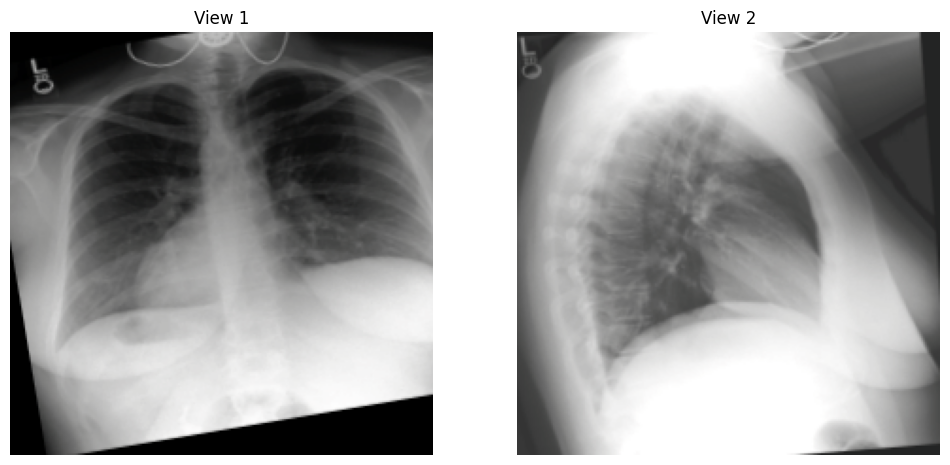


--- Sample Report (Decoded) ---
 the lungs are clear without focal consolidation . no pleural effusion or pneumothorax is seen . the cardiac and mediastinal silhouettes are unremarkable .  no acute cardiopulmonary process . 
Chexpert lables:-  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Chexpert Mask:-  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
--------------------------------------------------


In [13]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from glob import glob

# print("Loading pre-processed MIMIC-CXR dataset...")
# full_manifest = torch.load(MIMIC_DATA_PATH, map_location="cpu")
# print(f"Total studies loaded: {len(full_manifest)}")

print("Loading pre-processed MIMIC-CXR dataset chunks...")

# Find all chunk files
chunk_files = sorted(glob(os.path.join(MIMIC_DATA_PATH, "mimic_dataset_224_part_*.pt")))

# Load and merge all chunks
full_manifest = []
for chunk_path in chunk_files:
    print(f" → Loading {chunk_path}")
    data = torch.load(chunk_path, map_location="cpu")
    full_manifest.extend(data)

print(f"✅ Total studies combined: {len(full_manifest)}")

# Patient-level split to prevent data leakage
all_patients = sorted(list(set(m['subject_id'] for m in full_manifest)))
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    # Note the change from 'patient_id' to 'subject_id' here
    return [m for m in manifest if m['subject_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")

# --- 4) Datasets and DataLoaders ---
# Albumentations pipelines remain the same from your original code.
# The train_transform and val_transform objects should be defined before this.

train_dataset = MIMIC_CXR_Dataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = MIMIC_CXR_Dataset(val_manifest,   tokenizer, val_transform,   max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = MIMIC_CXR_Dataset(test_manifest,  tokenizer, val_transform,   max_seq_length=MAX_SEQ_LENGTH)

# The collate_fn and worker_init_fn are unchanged.
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn,
    worker_init_fn=_worker_init_fn, generator=g, persistent_workers=True, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,
    worker_init_fn=_worker_init_fn, generator=g, persistent_workers=True, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,
    worker_init_fn=_worker_init_fn, generator=g, persistent_workers=True, pin_memory=True
)

print("\nPyTorch DataLoaders for MIMIC-CXR are ready!")

# --- 5) CORRECTED Sanity Check and Visualization ---
print("\n--- Verifying a sample batch from the train_loader ---")
sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")
print(f"View mask shape:         {sample_batch['view_mask'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Chexpert Lables: {sample_batch['chexpert_labels'].shape}")
print(f"Chexpert mask: {sample_batch['chexpert_mask'].shape}")
# Visualize all views for a random study
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]
view_mask = sample_batch['view_mask'][idx_to_show]
num_views = view_mask.sum().item()

# De-normalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize=(6 * num_views, 6))
for i in range(num_views):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean # De-normalize
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1)) # Clamp to ensure valid range
    plt.subplot(1, num_views, i+1)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]

# === FIX FOR [EOS] TOKENS ===
# Use skip_special_tokens=True to get a clean, human-readable output
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
# ============================

print("\n--- Sample Report (Decoded) ---")
print(report_display)
print(f"Chexpert lables:-  {sample_batch['chexpert_labels'][idx_to_show]}")
print(f"Chexpert Mask:-  {sample_batch['chexpert_mask'][idx_to_show]}")
print("-" * 50)

# **MambaVision**

In [14]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MambaVisionEncoder(nn.Module):
    """
    A unified MambaVision class that can be used for multi-label classification
    (for pre-training) or as a powerful feature encoder for report generation.
    """
    def __init__(self, model_name="nvidia/MambaVision-S-1K", num_labels=14, device="cuda", dropout_rate=0.3,
                 for_report_generation=False, trained_classifier_path=None):
        super().__init__()
        self.device = device
        self.for_report_generation = for_report_generation

        # 1. Load the base MambaVision model from Hugging Face
        self.encoder = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True
        ).to(device)

        # 2. Infer hidden dimension from the model itself
        self.encoder.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224, device=device)
            pooled_feats, _ = self.encoder(dummy)
            hidden_dim = pooled_feats.shape[-1]

        print(f"Inferred hidden dimension: {hidden_dim}")

        # 3. Define the classification head (only used if for_report_generation is False)
        self.label_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        ).to(device)

        # 4. Load pre-trained weights if a path is provided (with robust loading)
        if trained_classifier_path:
            print(f"Loading pre-trained classifier weights from: {trained_classifier_path}")
            checkpoint = torch.load(trained_classifier_path, map_location=device)
            # Handle both raw state_dict and checkpoint dictionaries
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle weights from a compiled model (_orig_mod prefix)
            unwrapped_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
            
            # Use strict=False to gracefully handle loading only encoder weights
            # if the saved model doesn't have the classification head.
            self.load_state_dict(unwrapped_state_dict, strict=False)
            print("Successfully loaded pre-trained weights.")

        # 5. Set initial state
        self.encoder.eval()
        self.frozen = False
        self.freeze() # Start with the encoder frozen by default

    def forward(self, image_tensor):
        """
        Forward pass behavior depends on the 'for_report_generation' flag.
        """
        pooled_feats, features = self.encoder(image_tensor)
        
        if self.for_report_generation:
            # Mode 1: Report Generation - Return patch features
            last_stage_features = features[-1]
            patch_tokens = last_stage_features.flatten(2).permute(0, 2, 1)
            return patch_tokens, features
        else:
            # Mode 2: Classification - Return logits
            logits = self.label_head(pooled_feats)
            return logits, {'pooled': pooled_feats, 'patch': features}

    def freeze(self):
        self.frozen = True
        self.encoder.eval()
        print("Freezing encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.frozen = False
        self.encoder.train()
        print("Unfreezing all encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = True

    def unfreeze_encoder_top_layers(self, num_levels_to_unfreeze=1):
        if num_levels_to_unfreeze < 0 or num_levels_to_unfreeze > len(self.encoder.model.levels):
            raise ValueError("num_levels_to_unfreeze must be between 0 and 4.")

        self.freeze()
        if num_levels_to_unfreeze > 0:
            print(f"Unfreezing the last {num_levels_to_unfreeze} encoder level(s)...")
            self.frozen = False
            self.encoder.train()
            for i in range(num_levels_to_unfreeze):
                level_to_unfreeze = self.encoder.model.levels[-(i + 1)]
                for param in level_to_unfreeze.parameters():
                    param.requires_grad = True
        else:
            print("Encoder remains frozen.")

In [15]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# import numpy as np
# from torchvision import transforms
# import random

# # --- Global storage ---
# final_feature_map = None
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# # --- Hook to capture patch features ---
# def forward_hook(module, input, output):
#     global final_feature_map
#     final_feature_map = output.detach()  # [1, N, C]

# # --- Load model ---
# print("Instantiating model architecture...")
# inference_model = MambaVisionEncoder(
#     model_name="nvidia/MambaVision-S-1K",
#     for_report_generation=False,
#     trained_classifier_path="/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth",
#     device=DEVICE
# ).to(DEVICE)
# inference_model.eval()

# # --- Register hook on last mixer block ---
# target_layer = inference_model.encoder.model.levels[3].blocks[-1].mixer
# fwd_hook = target_layer.register_forward_hook(forward_hook)
# print(f"Hook registered on: {target_layer.__class__.__name__}")

# # --- Mean/Std for denorm ---
# mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(DEVICE)
# std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(DEVICE)

# # --- Visualization loop ---
# num_samples_to_show = 3
# print(f"\n--- Visualizing {num_samples_to_show} samples ---")

# sample_batch = next(iter(test_loader))
# images_batch = sample_batch["images"]  # (B, V, 3, H, W)
# view_mask = sample_batch.get("view_mask", None)

# selected_indices = random.sample(range(images_batch.size(0)), num_samples_to_show)

# for idx in selected_indices:
#     views = []
#     heatmaps = []

#     for v in range(images_batch.size(1)):
#         if view_mask is not None and view_mask[idx, v] == 0:
#             continue

#         img_tensor = images_batch[idx, v].unsqueeze(0).to(DEVICE)  # [1,3,H,W]

#         # --- Forward pass only ---
#         _ = inference_model(img_tensor)  # triggers hook

#         # --- Process patch features to 2D heatmap ---
#         fmap = final_feature_map[0]  # [N, C]
#         N, C = fmap.shape
#         h = w = int(np.sqrt(N))
#         fmap_2d = fmap.reshape(h, w, C)   # [H, W, C]

#         # Convert to heatmap: mean across channels
#         heatmap = fmap_2d.mean(axis=2).cpu().numpy()
#         heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # normalize
#         heatmap = F.interpolate(torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
#                                 size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()

#         # Denormalize image for display
#         disp_img = (images_batch[idx, v].cpu() * std.cpu() + mean.cpu()).clamp(0, 1)
#         pil_img = transforms.ToPILImage()(disp_img)

#         views.append(pil_img)
#         heatmaps.append(heatmap)

#     # --- Plot ---
#     num_views = len(views)
#     plt.figure(figsize=(5*num_views, 10))
#     for i, (orig, hmap) in enumerate(zip(views, heatmaps)):
#         plt.subplot(1, num_views, i+1)
#         plt.imshow(orig)
#         plt.imshow(hmap, cmap='jet', alpha=0.5)  # overlay heatmap
#         plt.title(f"Sample {idx} - View {i+1}")
#         plt.axis('off')
#     plt.show()

# # --- Cleanup ---
# fwd_hook.remove()
# print("\nVisualization complete. Hook removed successfully.")

# **EfficientMultiViewTransformerFusion**

In [16]:
class EfficientMultiViewTransformerFusion(nn.Module):
    def __init__(self, vision_dim, num_layers=1, num_heads=4, dropout=0.1, max_views=10):
        super().__init__()
        self.vision_dim = vision_dim
        self.max_views = max_views

        # Learnable view-level positional embeddings (broadcasted over patches of each view)
        self.view_pos_embed = nn.Parameter(torch.zeros(1, max_views, vision_dim))
        nn.init.trunc_normal_(self.view_pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vision_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Single learned query for attention pooling
        self.pool_query = nn.Parameter(torch.randn(1, 1, vision_dim))
        self.pool_attention = nn.MultiheadAttention(
            embed_dim=vision_dim, num_heads=num_heads, dropout=dropout, batch_first=True
        )

    def forward(self, feats, view_mask=None, num_patches_per_view=None):
        """
        feats: 
          - patch-level: (B, V * P, D) where P = num_patches_per_view (preferred for cross-attention)
          - view-level:  (B, V, D)      if passing pooled tokens per view
        view_mask: (B, V) with 1 for valid views, 0 for padded views
        num_patches_per_view: optional int; if None, inferred when possible
        """
        assert feats.dim() == 3, f"feats must be 3D [B, S, D], got {feats.shape}"

        B, S, D = feats.shape
        device = feats.device
        assert D == self.vision_dim, f"D mismatch: feats has {D}, fusion expects {self.vision_dim}"

        # Infer V and P
        if view_mask is not None:
            V = view_mask.size(1)
            if num_patches_per_view is None:
                assert S % V == 0, "Cannot infer patches per view; pass num_patches_per_view explicitly"
                P = S // V
            else:
                P = num_patches_per_view
                assert V * P == S or P == 1 and S == V, "Inconsistent S, V, P; check inputs"
        else:
            # No view_mask: assume either view-level (S=V, P=1) or require P
            if num_patches_per_view is None or num_patches_per_view == 1:
                V, P = S, 1
            else:
                assert S % num_patches_per_view == 0, "S must be divisible by P when inferring V"
                V, P = S // num_patches_per_view, num_patches_per_view

        # View positional embedding broadcast to patches
        assert V <= self.max_views, f"V={V} exceeds max_views={self.max_views}"
        view_pos = self.view_pos_embed[:, :V, :]  # [1, V, D]
        if P > 1:
            view_pos = view_pos.unsqueeze(2).expand(-1, -1, P, -1).reshape(1, V * P, D)  # [1, V*P, D]
        feats = feats + view_pos.to(device)

        # Build key_padding_mask over the token sequence (True = pad/ignore)
        key_padding_mask = None
        if view_mask is not None:
            if P == 1 and S == V:
                key_padding_mask = (view_mask == 0)
            else:
                vm = (view_mask == 0).unsqueeze(2)                   # [B, V, 1]
                vm = vm.expand(-1, -1, P).reshape(B, V * P)          # [B, V*P]
                key_padding_mask = vm
        # Transformer encode
        encoded = self.transformer(feats, src_key_padding_mask=key_padding_mask)  # [B, S, D]

        # Attention pooling with a learned query
        query = self.pool_query.expand(B, -1, -1).to(device)  # [B, 1, D]
        pooled, _ = self.pool_attention(
            query=query, key=encoded, value=encoded, key_padding_mask=key_padding_mask
        )  # [B, 1, D]
        return pooled.squeeze(1), encoded  # [B, D], [B, S, D]


# **Main Block**

In [17]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, custom_gpt2, fusion_module, device='cuda', use_all_views=True):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.gpt2 = custom_gpt2
        self.fusion_module = fusion_module
        self.device = torch.device(device)
        self.use_all_views = use_all_views
        vision_dim = self.fusion_module.vision_dim
        num_chexpert_labels = 14
        self.classification_head = nn.Linear(vision_dim, num_chexpert_labels)

    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None,
                chexpert_labels=None, chexpert_mask=None):
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)

        patch_feats_flat, _ = self.vision_encoder(images_flat)
        _, Num_Patches, _ = patch_feats_flat.shape
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, -1)

        fused_feats, encoded_views = self.fusion_module(
            patch_feats_seq, view_mask=view_mask, num_patches_per_view=Num_Patches
        )

        # --- THE CRITICAL CHANGE: VISUAL PREFIXING ---
        # 1. Get the standard word embeddings
        word_embeddings = self.gpt2.transformer.wte(input_ids) # Shape: (B, SeqLen, Dim)
        
        # 2. Treat the fused visual feature as a prefix. Shape: (B, 1, Dim)
        visual_prefix = fused_feats.unsqueeze(1)

        # 3. Concatenate the visual prefix with the word embeddings
        inputs_embeds = torch.cat([visual_prefix, word_embeddings], dim=1)

        # 4. Create a new attention mask for the combined sequence
        prefix_attention_mask = torch.ones(B, 1, dtype=torch.long, device=self.device)
        combined_attention_mask = torch.cat([prefix_attention_mask, attention_mask], dim=1)
        
        # 5. Create new labels that account for the prefix (prefix is not predicted)
        if labels is not None:
            prefix_labels = torch.full((B, 1), -100, dtype=torch.long, device=self.device)
            labels = torch.cat([prefix_labels, labels], dim=1)
        # --- END OF CRITICAL CHANGE ---

        # Text Generation with the new prefixed embeddings
        outputs = self.gpt2(
            inputs_embeds=inputs_embeds, # Use embeddings instead of input_ids
            attention_mask=combined_attention_mask,
            encoder_hidden_states=encoded_views, # Still use cross-attention as a second source
            labels=labels,
            return_dict=True
        )

        # Multi-Task Loss Calculation (remains the same)
        total_loss = outputs.loss
        if chexpert_labels is not None:
            chexpert_logits = self.classification_head(fused_feats)
            clf_loss_fn = nn.BCEWithLogitsLoss(weight=chexpert_mask)
            clf_loss = clf_loss_fn(chexpert_logits, chexpert_labels)
            loss_weight_clf = 0.2
            total_loss = outputs.loss + (loss_weight_clf * clf_loss)
        
        outputs.loss = total_loss
        return outputs
        
    # --- Freezing helpers (UPDATED: removed projection) ---
    def freeze_vision_encoder(self):
        if hasattr(self.vision_encoder, "freeze"): self.vision_encoder.freeze()
        else:
            for p in self.vision_encoder.parameters(): p.requires_grad = False

    def unfreeze_vision_encoder(self):
        if hasattr(self.vision_encoder, "unfreeze"): self.vision_encoder.unfreeze()
        else:
            for p in self.vision_encoder.parameters(): p.requires_grad = True

    def freeze_text_decoder(self):
        for p in self.gpt2.parameters(): p.requires_grad = False

    def unfreeze_text_decoder(self):
        for p in self.gpt2.parameters(): p.requires_grad = True
        
    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')


    def adapter_parameters(self):
        """
        Returns parameters for the 'adapter' components: fusion module, cross-attention,
        LM head, and token/positional embeddings. This is crucial for Phase 1.
        """
        adapter_params = list(self.fusion_module.parameters())
        
        # Explicitly add embeddings and the LM head
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' in name.lower() or 'lm_head' in name.lower() or 'wte' in name.lower() or 'wpe' in name.lower():
                if p.requires_grad:
                    adapter_params.append(p)
        
        # Ensure no duplicates
        return list(set(adapter_params))

    def gpt2_body_parameters(self):
        """
        Returns the main GPT-2 transformer block parameters, EXCLUDING adapters.
        This is necessary to avoid parameter overlap in the optimizer.
        """
        body_params = []
        adapter_param_ids = {id(p) for p in self.adapter_parameters()}
        
        for name, p in self.gpt2.named_parameters():
            if id(p) not in adapter_param_ids and p.requires_grad:
                body_params.append(p)
                
        return body_params

    def vision_encoder_parameters(self):
        """Returns all parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def freeze_decoder_body(self):
        """Freezes all parts of GPT-2 except cross-attention and the LM head."""
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' not in name.lower() and 'lm_head' not in name.lower():
                p.requires_grad = False

    # --- from_pretrained factory method (UPDATED) ---
    @classmethod
    def from_pretrained(cls, vision_encoder, fusion_module, tokenizer, device='cuda'):
        config = GPT2Config.from_pretrained("gpt2")
        config.add_cross_attention = True
        config.is_decoder = True
        config.output_attentions = True

        hf_gpt2 = GPT2LMHeadModel(config)
        pretrained = GPT2LMHeadModel.from_pretrained("gpt2")
        missing, unexpected = hf_gpt2.load_state_dict(pretrained.state_dict(), strict=False)
        print("Missing keys (cross-attn etc.):", len(missing), "Unexpected:", len(unexpected))
        hf_gpt2.resize_token_embeddings(len(tokenizer))

        return cls(
            vision_encoder=vision_encoder,
            custom_gpt2=hf_gpt2,
            fusion_module=fusion_module,
            device=device
        ).to(device)

In [18]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 768,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)



In [19]:
from types import SimpleNamespace
from pathlib import Path
# --- REVISED Training Configuration for LoRA ---
train_config = SimpleNamespace(
    # --- Simplified Epochs & Single-Phase Training ---
    epochs = 15, # LoRA often converges faster.

    # --- Learning Rate (Single LR for all adapter parameters) ---
    lr = 3e-5, # A good starting learning rate for LoRA with AdamW.

    # --- General Optimizer & Scheduler Settings ---
    device = 'cuda',
    model_path = Path('vl_captioner_lora_v1'), # New path for LoRA model
    batch_size = 8,
    optim = 'AdamW',
    weight_decay = 0.05,
    amsgrad = False,
    lr_scheduler = 'CosineAnnealingLR',
    T_max = 15,                      # Match total epochs
    eta_min = 1e-7,

    # --- Other Training Settings ---
    grad_accum_steps = 4,
    use_amp = True,
    wandb_project = "vl_captioner",
    wandb_run_name = "lora_finetune_v1",
    use_wandb = False,
)

In [20]:
import torch
import torch.nn as nn

def reinitialize_cross_attention_weights(model):
    """
    Properly initializes the weights of NEW cross-attention layers using a standard
    random initialization (Kaiming Normal), which is a best practice.
    This replaces the flawed strategy of copying self-attention weights.
    """
    print("Re-initializing cross-attention layers with Kaiming Normal...")
    
    for layer in model.gpt2.transformer.h:
        if hasattr(layer, 'crossattention'):
            # Initialize the attention projections (K, V, and output)
            nn.init.kaiming_normal_(layer.crossattention.c_attn.weight, nonlinearity='relu')
            nn.init.kaiming_normal_(layer.crossattention.c_proj.weight, nonlinearity='relu')
            
            # Initialize biases to zero
            if layer.crossattention.c_attn.bias is not None:
                nn.init.zeros_(layer.crossattention.c_attn.bias)
            if layer.crossattention.c_proj.bias is not None:
                nn.init.zeros_(layer.crossattention.c_proj.bias)
                
            print("  - Re-initialized one cross-attention block.")

    print("Cross-attention re-initialization complete.")

In [21]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 1. Instantiate the full model as before
vision_encoder = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=True,
    trained_classifier_path="/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth",
    device=DEVICE
).to(DEVICE)

fusion_module = EfficientMultiViewTransformerFusion(
    vision_dim=model_config.vision_dim,
    num_layers=4,
    num_heads=8,
    dropout=0.4
).to(train_config.device)

vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder=vision_encoder,
    fusion_module=fusion_module,
    tokenizer=tokenizer,
    device=train_config.device
)
reinitialize_cross_attention_weights(vl_model)
print("\n--- Trainable Parameters (Before any changes) ---")
vl_model.print_trainable_parameters()

# 2. CRITICAL: Freeze the non-decoder parts of the model
print("\n--- Freezing Vision and Fusion Modules ---")
vl_model.freeze_vision_encoder()
for param in vl_model.fusion_module.parameters():
    param.requires_grad = False

# 3. Define the LoRA configuration
lora_config_advanced = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["c_attn", 
                    "c_proj",
                    "c_fc"],
    lora_dropout=0.15,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# 4. Apply PEFT/LoRA to the GPT-2 decoder
print("\n--- Applying LoRA to the GPT-2 Decoder ---")
vl_model.gpt2 = get_peft_model(vl_model.gpt2, lora_config_advanced)

# 5. VERIFY the final trainable parameter count
print("\n--- Trainable Parameters (After LoRA and Freezing) ---")
vl_model.print_trainable_parameters()
# EXPECTED OUTPUT: The trainable params should now be ~1.5 Million, not 27 Million.

/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Successfully loaded pre-trained weights.
Freezing encoder layers.
Missing keys (cross-attn etc.): 96 Unexpected: 0


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Re-initializing cross-attention layers with Kaiming Normal...
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
  - Re-initialized one cross-attention block.
Cross-attention re-initialization complete.

--- Trainable Parameters (Before any changes) ---
Trainable params: 177,647,644 / 227,788,228

--- Freezing Vision and Fusion Modules ---
Freezing encoder layers.

--- Applying LoRA to the GPT-2 Decoder ---

--- Trainable Parameters (After LoRA and Freezing) ---
Trainable params: 6,605,852 / 233,981,380


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [22]:
import torch

def build_optimizer(args, model, verbose=True):
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optim_kwargs = {
        'params': [
            {'params': ve_params, 'lr': args.lr_ve, 'name': 'vision_encoder'},
            {'params': ed_params, 'lr': args.lr_ed, 'name': 'decoder'},
        ],
        'weight_decay': args.weight_decay
    }
    # Only add amsgrad if optimizer supports it
    if args.optim in ['Adam', 'AdamW']:
        optim_kwargs['amsgrad'] = getattr(args, 'amsgrad', False)

    optimizer = OptimClass(**optim_kwargs)

    # Debug print of param group assignments
    if verbose:
        print("\n[Optimizer Setup]")
        for i, pg in enumerate(optimizer.param_groups):
            n_params = sum(p.numel() for p in pg['params'])
            print(f" Group {i}: {pg.get('name','unnamed'):<15} | "
                  f"LR={pg['lr']:.6f} | Params={n_params:,}")

    return optimizer


def build_lr_scheduler(args, optimizer, steps_per_epoch=None, verbose=True):
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    if args.lr_scheduler == 'CosineAnnealingLR':
        T_max = args.epochs if steps_per_epoch is None else args.epochs * steps_per_epoch
        scheduler = SchedClass(optimizer, T_max=T_max, eta_min=args.eta_min)

    elif args.lr_scheduler == 'StepLR':
        scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)

    elif args.lr_scheduler == 'OneCycleLR':
        scheduler = SchedClass(
            optimizer,
            max_lr=[pg['lr'] for pg in optimizer.param_groups],
            epochs=args.epochs,
            steps_per_epoch=steps_per_epoch
        )
    else:
        scheduler = SchedClass(optimizer)

    if verbose:
        print(f"\n[Scheduler Setup] Using {args.lr_scheduler}")

    return scheduler

# **Trainer Class**

In [23]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import torchvision.transforms as transforms
import types 
from peft import PeftModel, get_peft_model
import copy
try:
    import wandb
except ImportError:
    wandb = None


def _ensure_scalar_loss(loss):
    """Make sure loss is a 0-dim tensor."""
    if isinstance(loss, (tuple, list)):
        loss = loss[0]
    if not torch.is_tensor(loss):
        loss = torch.as_tensor(loss, device='cuda' if torch.cuda.is_available() else 'cpu')
    if loss.dim() > 0:
        loss = loss.mean()
    return loss


class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device
        self.metrics = pd.DataFrame(
                    columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'],
                    index=range(train_config.epochs)
                )

        self.train_dl, self.val_dl = dls
        self.scaler = torch.amp.GradScaler(enabled=getattr(train_config, 'use_amp', True))
        self.grad_accum_steps = getattr(train_config, 'grad_accum_steps', 1)

        # Placeholder for optimizer and scheduler, will be built in fit()
        self.optim = None
        self.lr_scheduler = None
        self.opt_args = SimpleNamespace(
            optim=getattr(train_config, 'optim', 'AdamW'),
            weight_decay=getattr(train_config, 'weight_decay', 1e-4),
            amsgrad=getattr(train_config, 'amsgrad', False),
            lr_scheduler=getattr(train_config, 'lr_scheduler', 'StepLR'),
            epochs=train_config.epochs,
            eta_min=getattr(train_config,'eta_min', 1e-6),
            T_max=getattr(train_config, 'T_max', train_config.epochs)
        )

        # WandB integration (optional)
        self.use_wandb = getattr(train_config, 'use_wandb', False) and (wandb is not None)
        if self.use_wandb:
            try:
                wandb.init(project=getattr(train_config, 'wandb_project', 'vl_project'),
                           name=getattr(train_config, 'wandb_run_name', 'staged_training_run'),
                           config=vars(train_config))
                wandb.watch(self.vl_model, log="all")
            except Exception as e:
                print(f"WandB initialization failed: {e}")
                self.use_wandb = False

    def log_wandb(self, logs, step):
        if self.use_wandb:
            wandb.log(logs, step=step)

    def print_optimizer_param_groups(self, epoch_label):
        """
        Prints a table of optimizer param groups.
        Handles both integer epochs and string labels like 'Initial'.
        """
        rows = []
        for i, g in enumerate(self.optim.param_groups):
            n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
            if n_params == 0: continue
            rows.append({
                "group_name": g.get("name", f"group_{i}"),
                "lr": g["lr"],
                "weight_decay": g["weight_decay"],
                "n_params": f"{n_params:,}"
            })
        df = pd.DataFrame(rows)

        # --- THIS IS THE FIX ---
        # Checks if the label is a number for calculation, otherwise prints it directly.
        if isinstance(epoch_label, int):
            header = f"\n=== Optimizer Param Groups (Epoch {epoch_label + 1}) ==="
        else:
            header = f"\n=== Optimizer Param Groups ({epoch_label}) ==="
        print(header)
        # --- END OF FIX ---

        print(df.to_string(index=False))

    def save_model(self):
        """
        Saves the FULL model by merging LoRA weights into a temporary copy,
        leaving the original training model untouched. This is the robust solution.
        """
        model_path = self.train_config.model_path
        model_path.mkdir(exist_ok=True, parents=True)
        save_file_path = model_path / 'vl_model.pt'

        if isinstance(self.vl_model.gpt2, PeftModel):
            print("Creating a temporary model copy for saving with merged weights...")
            
            # 1. Create a temporary deep copy on the CPU to save memory
            temp_model = copy.deepcopy(self.vl_model).to('cpu')
            
            # 2. Merge the adapters in the temporary copy
            temp_model.gpt2 = temp_model.gpt2.merge_and_unload()
            
            # 3. Save the state_dict of the temporary, merged model
            torch.save(temp_model.state_dict(), save_file_path)
            
            print(f"Full model saved to {save_file_path}. Original model remains unchanged for training.")
            # 4. The temporary model is automatically discarded
        else:
            # If not a peft model, save normally
            torch.save(self.vl_model.state_dict(), save_file_path)
            print(f"Full model saved to {save_file_path}")

    # ===== NEW FUNCTION TO LOAD WEIGHTS FROM A SPECIFIC PATH =====
    def load_model_from_path(self, model_path):
        """
        Loads the VisionLanguageWrapper model weights from a specified file path.

        Args:
            model_path (str or pathlib.Path): The full path to the saved model state_dict (.pt file).
        """
        if not os.path.exists(model_path):
            print(f"Error: Model file not found at {model_path}")
            return

        print(f"Loading trained model weights from: {model_path}")
        try:
            # Load the state dictionary, ensuring it's mapped to the correct device
            state_dict = torch.load(model_path, map_location=self.device)
            
            # Load the state dictionary into the model
            self.vl_model.load_state_dict(state_dict)
            
            print("Model weights loaded successfully.")
            # It's good practice to put the model in evaluation mode after loading
            self.vl_model.eval()
        except Exception as e:
            print(f"An error occurred while loading the model weights: {e}")
    # =============================================================
    def load_best_model(self):
        """
        Loads the best FULL model weights from the saved .pt file.
        """
        model_path = self.train_config.model_path / 'vl_model.pt'
        print(f"Loading best full model weights from {model_path}")
        if not os.path.exists(model_path):
            print(f"Error: Model file not found at {model_path}")
            return
        if isinstance(self.vl_model.gpt2, PeftModel):
            print("Unloading adapters from current model to load full state_dict.")
            self.vl_model.gpt2 = self.vl_model.gpt2.merge_and_unload()
        try:
            state_dict = torch.load(model_path, map_location=self.device)
            self.vl_model.load_state_dict(state_dict)
            self.vl_model.to(self.device)
            self.vl_model.eval()
            print("Full model weights loaded successfully.")
        except Exception as e:
            print(f"An error occurred while loading the full model state_dict: {e}")

        
    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        self.optim.zero_grad(set_to_none=True)
        progress_bar = tqdm(self.train_dl, desc=f"Epoch {epoch+1} Training")

        for step, batch in enumerate(progress_bar):
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch['view_mask'].to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
            chexpert_mask = batch['chexpert_mask'].to(self.device, non_blocking=True)

            # --- STAGE 1: TRAIN VISION COMPONENTS ---
            # Unfreeze fusion module, freeze LoRA adapters
            for param in self.vl_model.fusion_module.parameters(): param.requires_grad = True
            for param in self.vl_model.classification_head.parameters(): param.requires_grad = True
            self.vl_model.gpt2.eval() # Put GPT2 in eval mode
            for param in self.vl_model.gpt2.parameters(): param.requires_grad = False
            
            with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
                # We only need the visual forward pass
                B, V, C, H, W = images.shape
                images_flat = images.view(B * V, C, H, W)
                patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
                _, Num_Patches, _ = patch_feats_flat.shape
                patch_feats_seq = patch_feats_flat.reshape(B, V*Num_Patches, -1)
                
                fused_feats, _ = self.vl_model.fusion_module(
                    patch_feats_seq, view_mask=view_mask, num_patches_per_view=Num_Patches
                )
                
                chexpert_logits = self.vl_model.classification_head(fused_feats.detach())
                clf_loss_fn = nn.BCEWithLogitsLoss(weight=chexpert_mask)
                classification_loss = clf_loss_fn(chexpert_logits, chexpert_labels)

            # Backpropagate classification loss
            self.scaler.scale(classification_loss).backward()
            
            # --- STAGE 2: TRAIN LANGUAGE COMPONENTS ---
            self.optim.zero_grad() # Zero grad before the second stage
            # Freeze fusion module, unfreeze LoRA adapters
            for param in self.vl_model.fusion_module.parameters(): param.requires_grad = False
            for param in self.vl_model.classification_head.parameters(): param.requires_grad = False
            self.vl_model.gpt2.train() # Put GPT2 back in train mode
            for param in self.vl_model.gpt2.parameters(): param.requires_grad = True

            with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
                # Full forward pass for text generation
                outputs = self.vl_model(
                    images, input_ids, attention_mask=attention_mask,
                    labels=labels, view_mask=view_mask
                )
                text_loss = outputs.loss

            # Backpropagate text loss
            self.scaler.scale(text_loss).backward()
            
            # --- OPTIMIZER STEP (after both stages) ---
            if (step + 1) % self.grad_accum_steps == 0:
                self.scaler.unscale_(self.optim)
                torch.nn.utils.clip_grad_norm_(self.vl_model.parameters(), 1.0)
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)

            total_loss = text_loss + classification_loss # For logging
            running_loss += total_loss.item()
            progress_bar.set_postfix(loss=total_loss.item())

        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Perplexity {train_pxp:.4f}")
        return train_loss

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        progress_bar = tqdm(self.val_dl, desc=f"Epoch {epoch+1} Validation")
        for batch in progress_bar:
            # (Validation logic remains the same, no need for two stages)
            images = batch['images'].to(self.device, non_blocking=True)
            # --- THE FIX IS ON THE NEXT LINE ---
            input_ids = batch['input_ids'].to(self.device, non_blocking=True) # Corrected variable name
            # --- END OF FIX ---
            labels = batch['labels'].clone()
            labels[labels == self.tokenizer.pad_token_id] = -100
            labels = labels.to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # We need to pass view_mask for the model's forward pass
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
    
            with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
                # The forward pass in validation does not need the CheXpert labels,
                # as the loss is calculated on text generation only.
                outputs = self.vl_model(
                    images,
                    input_ids=input_ids,  # Use the corrected variable name here
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask
                )
                loss = outputs.loss
            running_loss += _ensure_scalar_loss(loss).item()
            progress_bar.set_postfix(loss=loss.item())
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Perplexity {val_pxp:.4f}")
        return val_loss

    def clean(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


    def fit(self):
        best_loss = float('inf')
        best_epoch = -1
        patience = 5 # Increased patience as this training is more complex
        epochs_since_improvement = 0
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
        print("\n--- Two-Stage LoRA Training ---")
        
        # Optimizer now needs to know about all potentially trainable params
        self.optim = torch.optim.AdamW(
            self.vl_model.parameters(), lr=self.train_config.lr,
            weight_decay=self.train_config.weight_decay
        )
        self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
        
        for epoch in range(self.train_config.epochs):
            print(f"\n{'='*20} Epoch {epoch + 1}/{self.train_config.epochs} {'='*20}")
            train_loss = self.train_one_epoch(epoch)
            self.clean()
            val_loss = self.valid_one_epoch(epoch)
            self.clean()
            if self.lr_scheduler: self.lr_scheduler.step()
            if val_loss < best_loss:
                print(f"** Validation loss improved: {best_loss:.4f} -> {val_loss:.4f} (Epoch {epoch+1}) **")
                best_loss, best_epoch = val_loss, epoch
                self.save_model()
                epochs_since_improvement = 0
            else:
                epochs_since_improvement += 1
                print(f"No improvement for {epochs_since_improvement} epochs.")
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break
        print(f'\nTraining complete. Best validation loss: {best_loss:.4f} at epoch {best_epoch + 1}.')
        self.load_best_model()
        return {'best_val_loss': best_loss, 'best_epoch': best_epoch}

    
    def plot_loss_and_perplexity(self):
        if self.metrics.empty:
            print("No metrics available to plot yet.")
            return
    
        plottable_metrics = self.metrics.dropna()
        if plottable_metrics.empty:
            print("Metrics dataframe is empty after dropping NaNs. Cannot plot.")
            return
            
        epochs = plottable_metrics.index + 1
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].plot(epochs, plottable_metrics['train_loss'], label='Train Loss', marker='o')
        axes[0].plot(epochs, plottable_metrics['val_loss'], label='Val Loss', marker='o')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].plot(epochs, plottable_metrics['train_perplexity'], label='Train Perplexity', marker='o')
        axes[1].plot(epochs, plottable_metrics['val_perplexity'], label='Val Perplexity', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_yscale('log')
        axes[1].set_title('Training and Validation Perplexity (log scale)')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def clean_and_format_report(self, generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines, seen = [], set()
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in seen:
                    lines.append(line)
                    seen.add(line)
            sections[k] = " ".join(lines).strip()
        return f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"

    @torch.no_grad()
    def robust_generate_radiology_report(self, image_input, max_tokens=350, temperature=1.0,
                                         top_k=None, top_p=None, beam_width=1,
                                         temperature_range=None, deterministic=False, show_image=False):
        self.vl_model.eval()

        if not isinstance(image_input, list):
            image_input = [image_input]
        img_list = [Image.open(img).convert('RGB') if isinstance(img, (str, bytes, os.PathLike)) else img.convert('RGB') for img in image_input]

        if show_image:
            plt.figure(figsize=(6 * len(img_list), 6))
            for i, img in enumerate(img_list):
                plt.subplot(1, len(img_list), i + 1)
                plt.imshow(img); plt.axis('off')
            plt.show()

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        imgs_pp = torch.stack([transform(img) for img in img_list]).unsqueeze(0).to(self.device)
        num_views = imgs_pp.shape[1]
        view_mask = torch.ones(1, num_views, device=self.device)
        section_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")

        if temperature_range and not deterministic:
            low, high = temperature_range
            temperature = float(np.random.uniform(low, high))

        def encode_visual():
            images_flat = imgs_pp.view(-1, *imgs_pp.shape[2:])
            patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
            _, num_patches, vision_dim = patch_feats_flat.shape
            
            num_views = imgs_pp.shape[1]
            patch_feats_seq = patch_feats_flat.reshape(1, num_views * num_patches, vision_dim)
            
            _ , encoded_views_seq = self.vl_model.fusion_module(
                patch_feats_seq,
                view_mask=view_mask,
                num_patches_per_view=num_patches
            )
            return encoded_views_seq

        visual_emb = encode_visual()

        def step_once(seq):
            logits = self.vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
            filt = logits.clone()
            if top_k is not None:
                k = int(min(top_k, filt.size(-1)))
                thresh = torch.topk(filt, k)[0][..., -1, None]
                filt[filt < thresh] = -float('Inf')
            if top_p is not None:
                sorted_logits, idx = torch.sort(filt, descending=True)
                cumprobs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                remove = cumprobs > top_p
                remove[..., 1:] = remove[..., :-1].clone()
                remove[..., 0] = 0
                filt.scatter_(1, idx[remove], -float('Inf'))
            probs = torch.softmax(filt, dim=-1)
            return torch.multinomial(probs, 1) if not deterministic else torch.argmax(probs, dim=-1, keepdim=True)

        if beam_width > 1:
            sequences = [(torch.tensor([[section_token_id]], device=self.device), 0.0)]
            for _ in range(max_tokens):
                all_cands = []
                for seq, score in sequences:
                    logits = self.vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
                    log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)
                    topk_lp, topk_idx = torch.topk(log_probs, beam_width)
                    for k in range(beam_width):
                        next_t = topk_idx[k].unsqueeze(0).unsqueeze(0)
                        all_cands.append((torch.cat([seq, next_t], 1), score + topk_lp[k].item()))
                sequences = sorted(all_cands, key=lambda x: x[1], reverse=True)[:beam_width]
                if all(seq[0, -1].item() == self.tokenizer.eos_token_id for seq, _ in sequences):
                    break
            seq_tensor = sequences[0][0]
        else:
            seq_tensor = torch.tensor([[section_token_id]], device=self.device)
            for _ in range(max_tokens):
                next_tok = step_once(seq_tensor)
                seq_tensor = torch.cat([seq_tensor, next_tok], 1)
                if next_tok.item() == self.tokenizer.eos_token_id:
                    break

        report = self.tokenizer.decode(seq_tensor.squeeze(0).tolist(), skip_special_tokens=False)
        return self.clean_and_format_report(report)

In [24]:
trainer = Trainer(
    vl_model,
    tokenizer,
    train_config,
    (train_loader, val_loader)
)


In [25]:
# trainer.load_model_from_path("/kaggle/input/mimic-cxr-model/vl_model.pt")

In [26]:
trainer.fit() 


--- Two-Stage LoRA Training ---

[Scheduler Setup] Using CosineAnnealingLR

==================== Epoch 1/15 ====================


Epoch 1 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
/tmp/ipykernel_3198/1593404124.py:230: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
Epoch 1 Training: 100%|██████████| 2802/2802 [27:28<00:00,  1.70it/s, loss=2.91] 


Epoch 1: Train Loss 3.1061, Perplexity 22.3336


Epoch 1 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:280: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 1 Validation: 100%|██████████| 372/372 [01:25<00:00,  4.34it/s, loss=0.521]


Epoch 1: Val Loss 2.0004, Perplexity 7.3919
** Validation loss improved: inf -> 2.0004 (Epoch 1) **
Creating a temporary model copy for saving with merged weights...
Full model saved to vl_captioner_lora_v1/vl_model.pt. Original model remains unchanged for training.

==================== Epoch 2/15 ====================


Epoch 2 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
/tmp/ipykernel_3198/1593404124.py:230: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 2 Training: 100%|██████████| 2802/2802 [27:27<00:00,  1.70it/s, loss=2.01] 


Epoch 2: Train Loss 1.9625, Perplexity 7.1168


Epoch 2 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:280: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 2 Validation: 100%|██████████| 372/372 [01:24<00:00,  4.38it/s, loss=0.403]


Epoch 2: Val Loss 1.7416, Perplexity 5.7063
** Validation loss improved: 2.0004 -> 1.7416 (Epoch 2) **
Creating a temporary model copy for saving with merged weights...
Full model saved to vl_captioner_lora_v1/vl_model.pt. Original model remains unchanged for training.

==================== Epoch 3/15 ====================


Epoch 3 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
/tmp/ipykernel_3198/1593404124.py:230: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 3 Training: 100%|██████████| 2802/2802 [27:24<00:00,  1.70it/s, loss=2.12] 


Epoch 3: Train Loss 1.7699, Perplexity 5.8704


Epoch 3 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:280: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 3 Validation: 100%|██████████| 372/372 [01:24<00:00,  4.40it/s, loss=0.287]


Epoch 3: Val Loss 1.6266, Perplexity 5.0864
** Validation loss improved: 1.7416 -> 1.6266 (Epoch 3) **
Creating a temporary model copy for saving with merged weights...
Full model saved to vl_captioner_lora_v1/vl_model.pt. Original model remains unchanged for training.

==================== Epoch 4/15 ====================


Epoch 4 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
/tmp/ipykernel_3198/1593404124.py:230: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 4 Training: 100%|██████████| 2802/2802 [27:25<00:00,  1.70it/s, loss=1.73] 


Epoch 4: Train Loss 1.6692, Perplexity 5.3080


Epoch 4 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:280: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 4 Validation: 100%|██████████| 372/372 [01:22<00:00,  4.50it/s, loss=0.316]


Epoch 4: Val Loss 1.5532, Perplexity 4.7268
** Validation loss improved: 1.6266 -> 1.5532 (Epoch 4) **
Creating a temporary model copy for saving with merged weights...
Full model saved to vl_captioner_lora_v1/vl_model.pt. Original model remains unchanged for training.

==================== Epoch 5/15 ====================


Epoch 5 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
/tmp/ipykernel_3198/1593404124.py:230: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 5 Training: 100%|██████████| 2802/2802 [27:19<00:00,  1.71it/s, loss=1.77] 


Epoch 5: Train Loss 1.5988, Perplexity 4.9470


Epoch 5 Validation:   0%|          | 0/372 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:280: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 5 Validation: 100%|██████████| 372/372 [01:24<00:00,  4.40it/s, loss=0.265]


Epoch 5: Val Loss 1.5214, Perplexity 4.5786
** Validation loss improved: 1.5532 -> 1.5214 (Epoch 5) **
Creating a temporary model copy for saving with merged weights...
Full model saved to vl_captioner_lora_v1/vl_model.pt. Original model remains unchanged for training.

==================== Epoch 6/15 ====================


Epoch 6 Training:   0%|          | 0/2802 [00:00<?, ?it/s]/tmp/ipykernel_3198/1593404124.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
/tmp/ipykernel_3198/1593404124.py:230: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.train_config.use_amp):
Epoch 6 Training:   1%|          | 17/2802 [00:10<29:58,  1.55it/s, loss=1.43] 


KeyboardInterrupt: 

# **Loading Trained Model**

In [31]:
trainer.load_best_model()

Loading best full model weights from vl_captioner_lora_v1/vl_model.pt
Unloading adapters from current model to load full state_dict.
Full model weights loaded successfully.


# **Report Genearation**

In [ ]:
report_beam = trainer.robust_generate_radiology_report(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png"],
    max_tokens=200,
    deterministic=True,
    beam_width=2,
    show_image=True # Set to True if you want to see the image
)

print("Generated report (beam):\n", report_beam)

In [ ]:
# from torch.utils.data import ConcatDataset, DataLoader
# from PIL import Image
# from nltk.tokenize import word_tokenize
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from nltk.translate.meteor_score import single_meteor_score
# from rouge_score import rouge_scorer
# from tqdm import tqdm
# import pandas as pd
# def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
#     results = []
#     sample_count = 0
#     smooth = SmoothingFunction()
#     rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

#     for batch in tqdm(dataloader, desc="Evaluating dataset"):
#         input_ids = batch['input_ids']
#         image_paths_list = batch['image_paths']  # <- list of lists: one per sample

#         for i in range(len(image_paths_list)):
#             if max_samples and sample_count >= max_samples:
#                 break

#             gt_input_ids = input_ids[i]
#             if tokenizer.pad_token_id is not None:
#                 gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
#             reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
#             if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
#                 continue

#             # --- Load all image views for this report ---
#             pil_imgs = []
#             for image_path in image_paths_list[i]:
#                 pil_img = Image.open(image_path).convert('RGB')
#                 pil_imgs.append(pil_img)
#             # --- Generate report from all images for this study ---
#             gen_report = trainer.robust_generate_radiology_report(
#                 pil_imgs,
#                 max_tokens=350,
#                 deterministic=True,
#                 beam_width=1,
#             )
            
            
#             # --- TOKENIZATION FOR METRICS ---
#             ref_tokens = word_tokenize(reference_text)
#             hyp_tokens = word_tokenize(gen_report)
#             # BLEU scores for n = 1, 2, 3, 4
#             bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
#             bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
#             bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
#             bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

#             # METEOR (pass as strings, NOT as lists)
#             meteor = single_meteor_score(ref_tokens, hyp_tokens)


#             # ROUGE-L
#             rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

#             results.append({
#                 'BLEU-1': bleu1,
#                 'BLEU-2': bleu2,
#                 'BLEU-3': bleu3,
#                 'BLEU-4': bleu4,
#                 'METEOR': meteor,
#                 'ROUGE-L': rouge_l_score
#             })
#             sample_count += 1
#             if max_samples and sample_count >= max_samples:
#                 break
#         if max_samples and sample_count >= max_samples:
#             break

#     results_df = pd.DataFrame(results)
#     avg_scores = results_df.mean().to_dict()
#     return results_df, avg_scores

# # --- Example usage ---
# results_df, avg_scores = evaluate_dataloader_metrics_v2(test_loader, trainer, tokenizer, train_config.device)
# print(results_df)
# print('Average Scores:', avg_scores)


In [27]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_test_samples(trainer, test_loader, tokenizer, num_samples=5):
    """
    Selects random samples from a batch of the test_loader, displays the images,
    and compares the ground truth report to the model-generated report.
    """
    # Ensure the model is in evaluation mode
    trainer.vl_model.eval()

    # De-normalization constants for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    print(f"Fetching a batch from the test loader to evaluate {num_samples} random samples...")
    try:
        # Get a single batch from the test_loader
        sample_batch = next(iter(test_loader))
    except StopIteration:
        print("Test loader is empty. Cannot evaluate.")
        return

    images_batch = sample_batch['images']      # Shape: (batch, max_views, 3, H, W)
    input_ids_batch = sample_batch['input_ids']    # Shape: (batch, seq_len)
    view_mask_batch = sample_batch['view_mask']    # Shape: (batch, max_views)

    # Ensure we don't try to sample more than we have in the batch
    actual_batch_size = images_batch.size(0)
    if actual_batch_size == 0:
        print("Batch is empty. Cannot evaluate.")
        return
        
    num_samples_to_show = min(num_samples, actual_batch_size)
    
    # Select random indices from the batch
    selected_indices = random.sample(range(actual_batch_size), num_samples_to_show)

    for i, idx in enumerate(selected_indices):
        print(f"\n{'='*30} EVALUATING SAMPLE {i+1}/{num_samples_to_show} {'='*30}")
        
        # This list will hold the un-normalized PIL images for the current study
        pil_images_for_generation = []
        
        # Get the valid views for the selected study using the view_mask
        view_mask = view_mask_batch[idx]
        num_views = int(view_mask.sum())
        
        plt.figure(figsize=(6 * num_views, 6))

        for view_idx in range(view_mask.size(0)):
            if view_mask[view_idx].item() == 1:  # Process only valid views
                # Get the normalized image tensor from the batch
                image_tensor = images_batch[idx, view_idx].cpu()
                
                # De-normalize the tensor to create a displayable image
                display_image_tensor = (image_tensor * std) + mean
                display_image_tensor = torch.clamp(display_image_tensor, 0, 1)
                pil_img = transforms.ToPILImage()(display_image_tensor)
                
                pil_images_for_generation.append(pil_img)
                
                # Plot the de-normalized image
                plt.subplot(1, num_views, len(pil_images_for_generation))
                plt.imshow(pil_img)
                plt.title(f"View {len(pil_images_for_generation)}")
                plt.axis('off')
        
        plt.show()

        # Decode the ground truth report
        ground_truth_ids = input_ids_batch[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate the report from the list of PIL images
        # The robust_generate_radiology_report function will handle the necessary transformations internally
        generated_report = trainer.robust_generate_radiology_report(
            image_input=pil_images_for_generation,
            max_tokens=350,
            deterministic=True, # Use deterministic for consistent evaluation
            beam_width=2,       # Beam search can produce better results
        )

        # Display the comparison
        print(f"\n--- Ground Truth Report ---")
        print(ground_truth_report.strip())
        print(f"\n--- Generated Report ---")
        print(generated_report.strip())
        print("-" * 80)



Fetching a batch from the test loader to evaluate 5 random samples...

============================== EVALUATING SAMPLE 1/4 ==============================


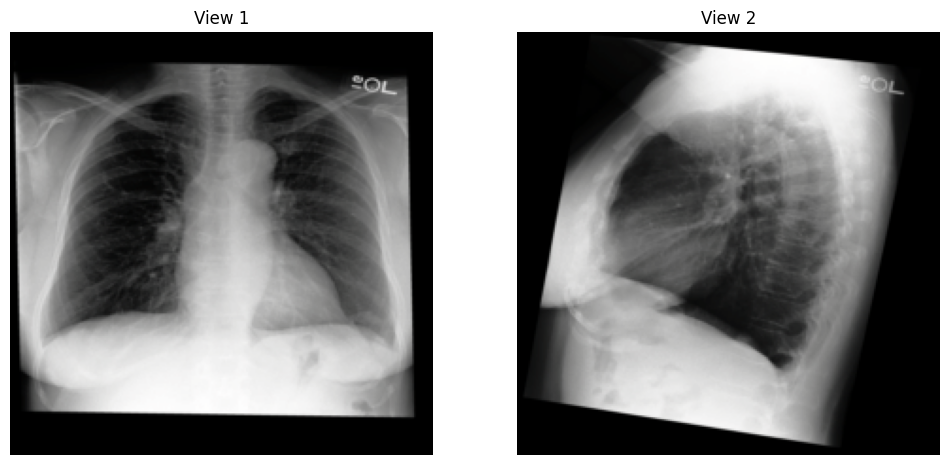

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



--- Ground Truth Report ---
there is mild left base atelectasis seen on the frontal view without clear correlate on the lateral view . no definite focal consolidation is seen . there is no pleural effusion or pneumothorax . the aorta is slightly tortuous . the cardiac silhouette is not enlarged . there is no overt pulmonary edema .  mild left base atelectasis . otherwise no acute cardiopulmonary process .

--- Generated Report ---
Findings: 
Impression: no acute intrathoracic process . <|endoftext|>
--------------------------------------------------------------------------------

============================== EVALUATING SAMPLE 2/4 ==============================


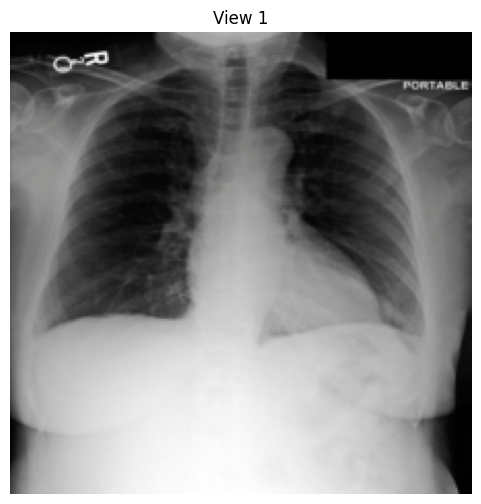


--- Ground Truth Report ---
as compared to the previous radiograph there is evidence of an unchanged picc line placed over the right upper extremity . the tip appears to project over the azygous vein at the level of the upper svc . no complications notably no pneumothorax . borderline size of the cardiac silhouette . moderate tortuosity of the thoracic aorta .

--- Generated Report ---
Findings: 
Impression: no acute cardiopulmonary process . <|endoftext|> <|endoftext|> no acute cardiopulmonary process . <|endoftext|> <|endoftext|> <|endoftext|> no acute cardiopulmonary process . <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> no acute cardiopulmonary process . <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> no acute cardiopulmonary process . <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> no acute cardiopulmonary process . <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|>

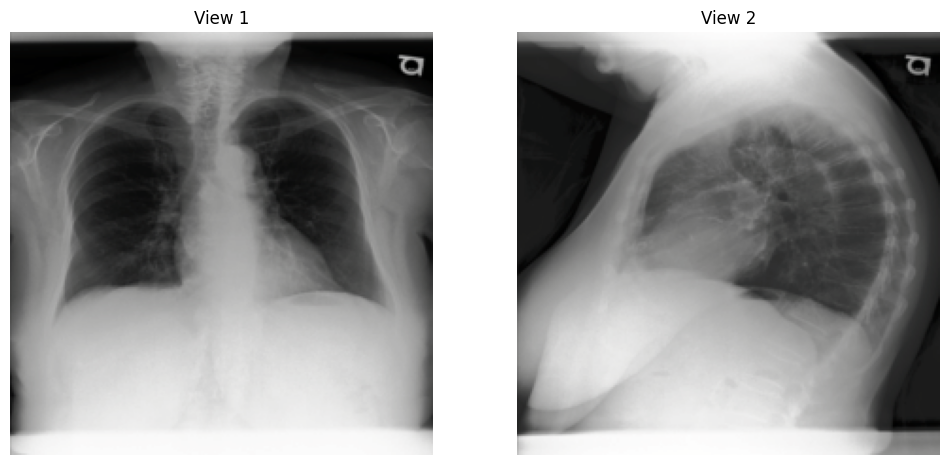


--- Ground Truth Report ---
as compared to the prior examination dated there has been no significant interval change . there is no evidence of focal consolidation pleural effusion pneumothorax or frank pulmonary edema . the cardiomediastinal silhouette is within normal limits . there is persistent thoracic kyphosis with mild wedging of a mid thoracic vertebral body .  no evidence of acute cardiopulmonary process .

--- Generated Report ---
Findings: 
Impression: no acute intrathoracic process . <|endoftext|>
--------------------------------------------------------------------------------

============================== EVALUATING SAMPLE 4/4 ==============================


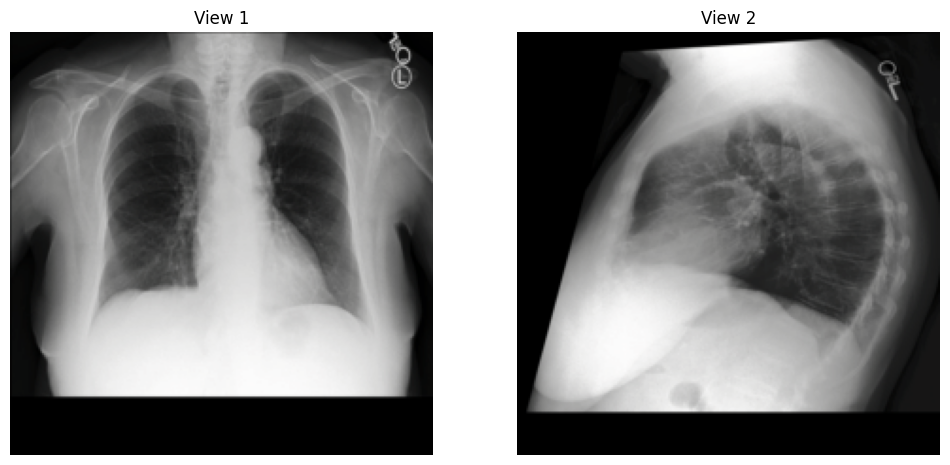


--- Ground Truth Report ---
pa and lateral views of the chest provided . lung volumes are somewhat low . there is no focal consolidation effusion or pneumothorax . the cardiomediastinal silhouette is normal . imaged osseous structures are intact . no free air below the right hemidiaphragm is seen .  no acute intrathoracic process .

--- Generated Report ---
Findings: 
Impression: no acute cardiopulmonary process . <|endoftext|>
--------------------------------------------------------------------------------


In [28]:
evaluate_on_test_samples(trainer, test_loader, tokenizer, num_samples=5)

In [ ]:
trainer.plot_loss_and_perplexity()